# Cart endgame

## Import and load the original data

In [6]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

In [7]:
data = Loader.load_by_fueltype("Eléctrico")
label_encoder = LabelEncoder()
data["price_categ"].value_counts()

d:\Código\ProyectoML\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Código\ProyectoML\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Código\ProyectoML\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mer

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

### Describe some columns
A more detailed version of the dataset can be found in the DataDescription.ipynb

In [8]:
data.select_dtypes(include=['category'])

,color,brand,model,version,fuelType,bodyTypeId,transmissionTypeId,province,environmentalLabel,jato_classification,...,Acabado Exterior_Pintura,Acabado Exterior_Rueda,AC_Zones,AC_Type,Metodo_Apertura,Tipo_Faro,interior_clock,arm_suppport_front,arm_suppport_back,price_categ
idx,,,,,,,,,,,,,,,,,,,,,
3,Rosa,FIAT,500,laPrima 31 320km 85kW 118CV,Eléctrico,Berlina,Automatico,Barcelona,0,L1,...,pintura metalizada,no tiene,MONOZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,no tiene,Middle range
7,Blanco (Serenity white),HYUNDAI,Kona,EV 115kW 48kWh Flexx,Eléctrico,SUV,Automatico,Barcelona,0,M1,...,pintura solida,no tiene,BIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Middle high range
10,Blanco,RENAULT,Kangoo Furgon,L1 Start EV45 22kW,Eléctrico,Furgoneta,Automatico,Asturias,NaN,B1,...,pintura solida,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Middle high range
14,Azul,PEUGEOT,e-208,Allure Electrico 136 100 Kw,Eléctrico,Berlina,Automatico,Valencia,NaN,M4,...,pintura metalizada,no tiene,MONOZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,no tiene,Middle range
18,Gris / Plata,AUDI,e-tron GT,RS quattro 440kW 598CV,Eléctrico,Berlina,Automatico,Vizcaya,0,B1,...,pintura solida,no tiene,TRIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164732,Blanco (White Silver),MINI,MINI,COOPER SE,Eléctrico,Berlina,Automatico,Albacete,0,M2,...,pintura metalizada,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,no tiene,Middle range
164840,Negro,SMART,fortwo,60kW81CV EQ coupe,Eléctrico,Berlina,Automatico,Madrid,0,B1,...,pintura negra,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Budget
164991,Negro,SMART,fortwo,60kW81CV electric drive coupe,Eléctrico,Berlina,Automatico,Zaragoza,0,B1,...,pintura solida,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Budget


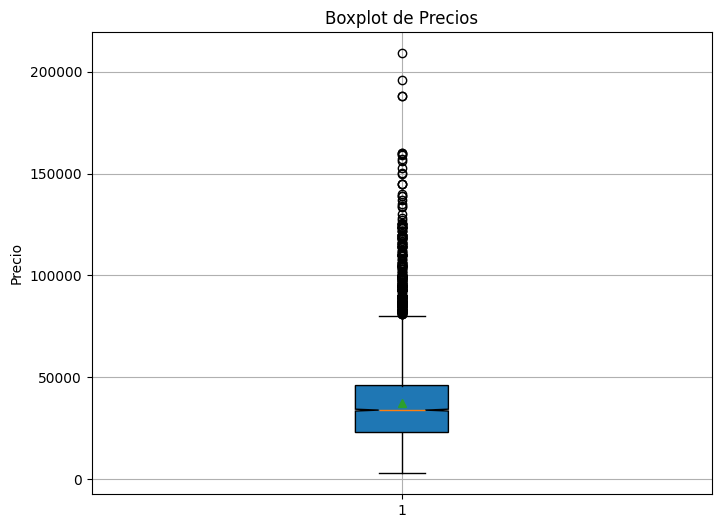

In [9]:
precios_electricos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [10]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

80525.0


,price,brand
idx,,
28269,209000,MASERATI
85726,196000,MASERATI
144182,188000,MERCEDES-BENZ
134773,188000,MERCEDES-BENZ
21981,159900,PORSCHE
...,...,...
1917,81400,MERCEDES-BENZ
28058,80900,AUDI
134254,80900,MERCEDES-BENZ


# Electric cars

## Numerical variables selection Eléctrico
Here we will perform PCA and use correlation matrix to select the most correlated numerical variables

In [11]:
def fill_electric_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.range_KM")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_electric_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id", "electricFeatures.maxPower_CV"], inplace=True) # electricFeatures.maxPower_CV is = power_cv (Duplicated colums)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_electric_numerical_columns(numerical_columns)

In [12]:
numerical_columns = get_electric_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6468475373043994%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 16.91508204296949%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.689473571028928%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 13.035625391285748%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 11.85488371952156%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 17.854083487783583%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'power_kw', 'dimensions.length', 'dimensions.height', 'dimensions.width'] -> electricFeatures.combinedConsumption_kWh/: 17.20475510968712%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'electricFeatures.combinedConsumption_kWh/', 'power_kw'] -> electricFeatures.range_KM: 16.16138222681962%


In [13]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                                        1.000000
km                                          -0.343331
year                                         0.459700
doors                                        0.092279
seatingCapacity                              0.257532
trunkCapacityInLiters                        0.301739
maxSpeed                                     0.655830
acceleration                                -0.582307
power_cv                                     0.709338
power_kw                                     0.712126
max_torque_nm                                0.677488
speakers                                     0.294090
dimensions.width                             0.689372
dimensions.height                            0.055209
dimensions.length                            0.613427
Numero_Testigos                              0.183137
Llantas_Diametro_cm                          0.633856
electricFeatures.range_KM                    0.600411
electricFeatures.maximumBatt

In [14]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

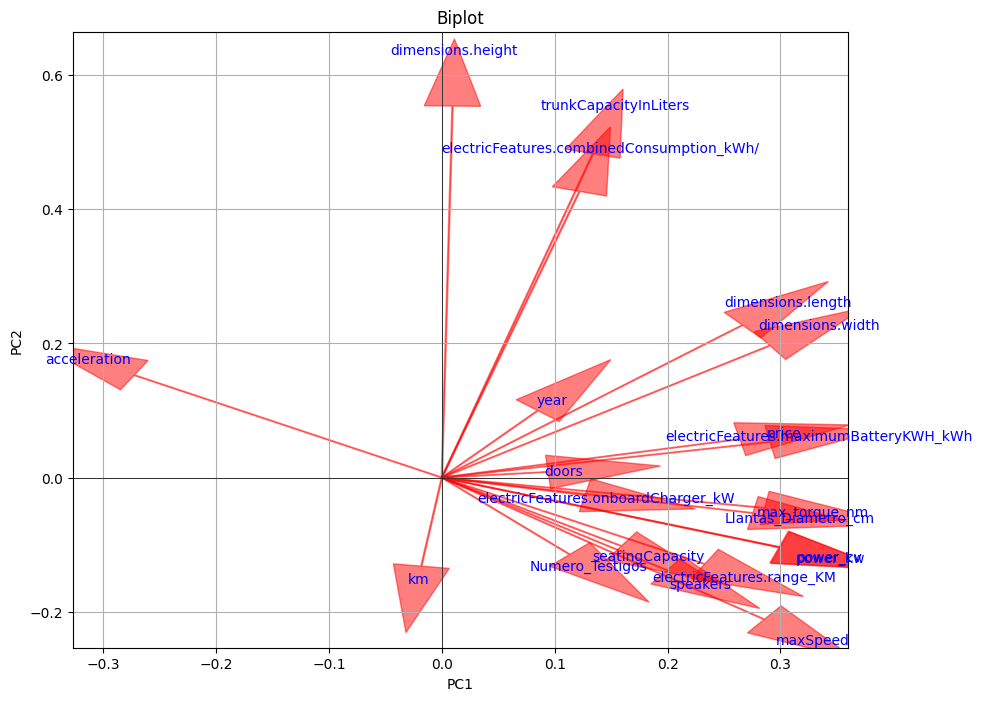

In [15]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

In [16]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 3797.7874090960577 MSE: 46990581.73604466 RMSE: 6854.967668490104 R2: 0.9002451945445614 MAPE: 10.387670654715645
Mean: 3797.7874090960577
Variance: 32567392.53135611
Standard Deviation: 5706.784780535894


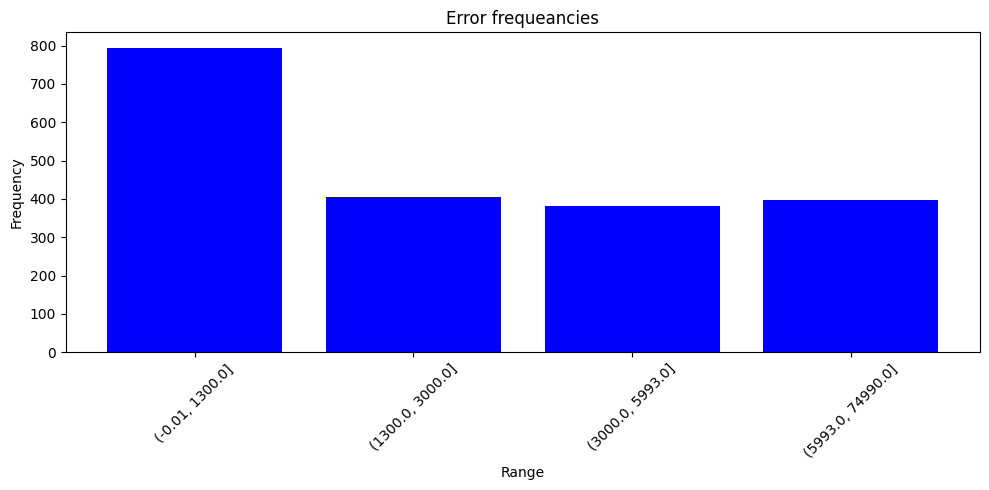

{'(-0.01, 1300.0]': 795, '(1300.0, 3000.0]': 406, '(3000.0, 5993.0]': 381, '(5993.0, 74990.0]': 396}


In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

evaluator.eval_regression(y_pred, y_test)

## Electrico categorical variables
Here we will perform CA and Chi2 test to select the best categorical variables

In [18]:
def get_electric_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [19]:
categorical_columns = get_electric_categorical_columns(data)

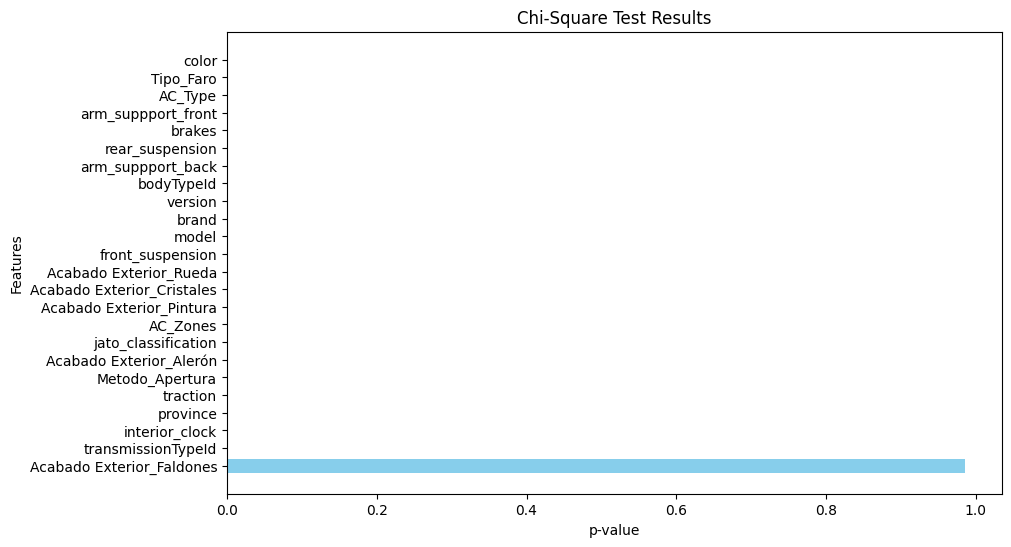

,Feature,Chi2 Stat,p-value
0,color,17355.917738,0.000000e+00
20,Tipo_Faro,1590.069687,0.000000e+00
18,AC_Type,1486.737498,0.000000e+00
22,arm_suppport_front,3759.181818,0.000000e+00
9,brakes,1581.335781,0.000000e+00
11,rear_suspension,1848.387572,0.000000e+00
23,arm_suppport_back,2401.453330,0.000000e+00
4,bodyTypeId,6530.816750,0.000000e+00
3,version,19903.204434,0.000000e+00
1,brand,1800.198086,0.000000e+00


In [20]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

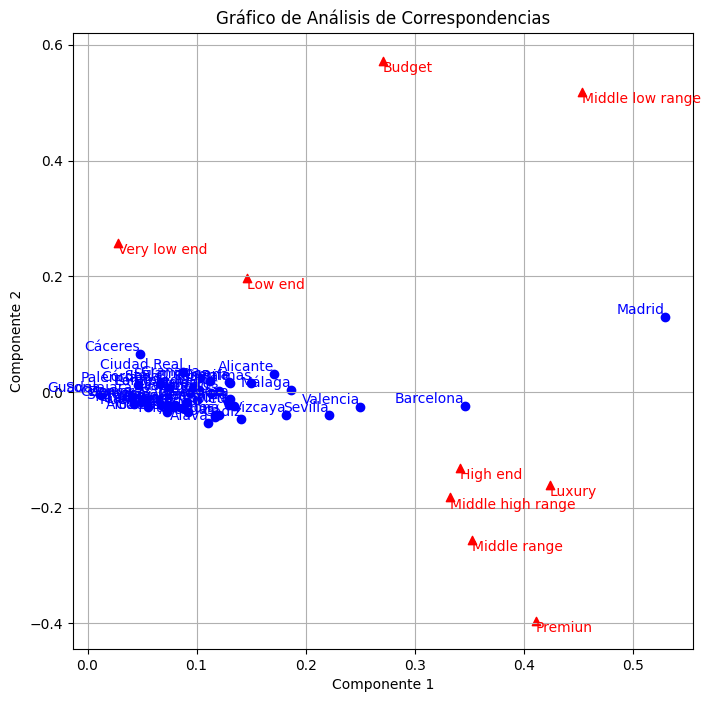

In [21]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [22]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

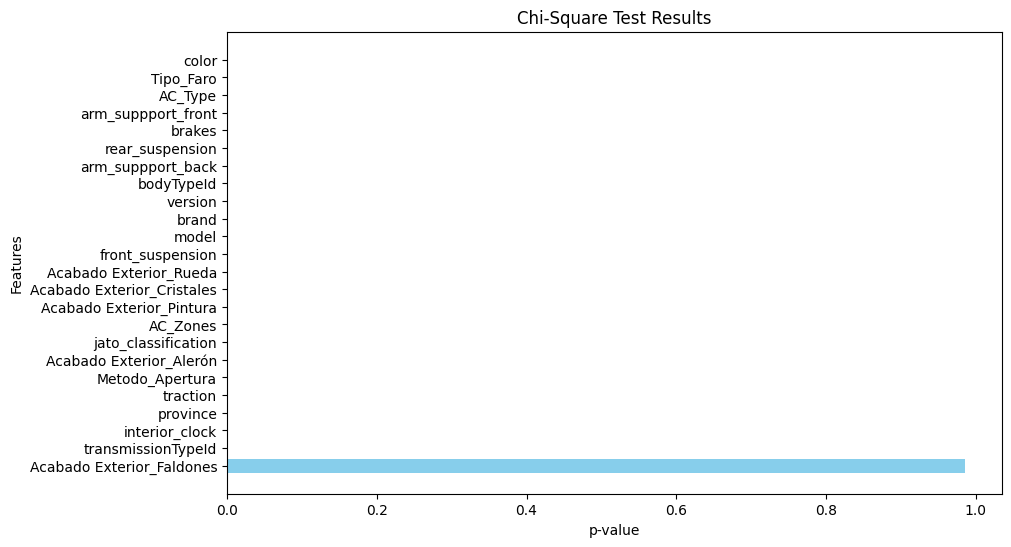

Index(['color', 'Tipo_Faro', 'AC_Type', 'arm_suppport_front', 'brakes',
       'rear_suspension', 'arm_suppport_back', 'bodyTypeId', 'version',
       'brand', 'model', 'price_categ'],
      dtype='object')

In [23]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

## Test CART tree classifier with only categorical values

In [24]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [25]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
3922,Luxury,Premiun,1
6212,Middle range,Budget,1
5402,High end,Middle high range,1
5078,Budget,Middle low range,1
3019,Luxury,Premiun,1
...,...,...,...
678,Luxury,Luxury,0
5399,High end,Middle high range,1
953,Premiun,Luxury,1
5639,Luxury,Premiun,1


In [26]:
# Calcular la precisión
evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.6521739130434783 Precision: 0.6504697261164527 Recall: 0.6521739130434783 F1 Score: 0.6501109806022837
Confusion Matrix:
 [[322   7   2   0  10  23  42   0   0]
 [  7 101   0   8  47   0  21  46   0]
 [  2   0  34   0   0   6   0   0   0]
 [  1   8   0 292   7   0   1  46   0]
 [ 22  29   2   4 100   1  51   9   0]
 [ 29   0  17   0   0  98   0   0   1]
 [ 63  13   1   1  38   0 126   4   0]
 [  3  43   0  46  21   0   4 217   0]
 [  0   0   1   0   0   1   0   0   0]]


We can verify that the prediction is not very accurate but we need to know how big is the error.

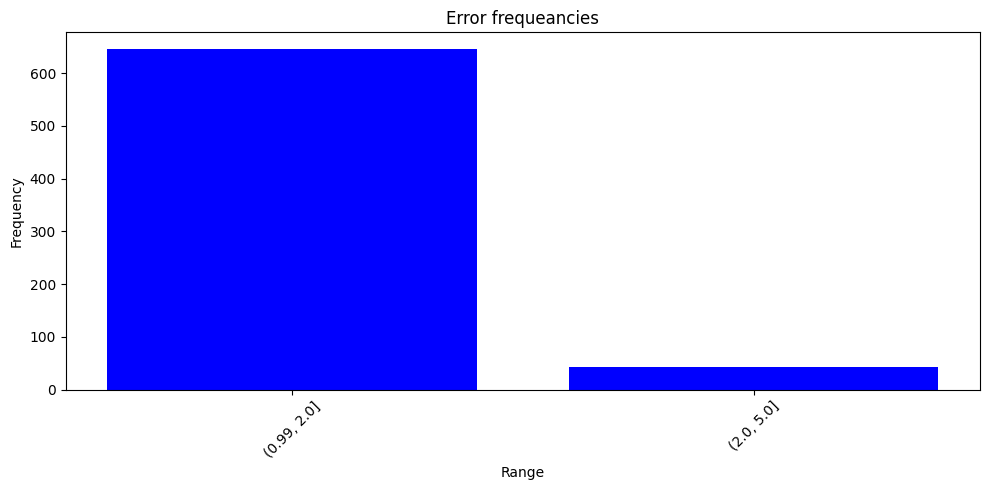

Errors: {'(0.99, 2.0]': 645, '(2.0, 5.0]': 43}
Error mean: 1.309593023255814
Error rate: 34.78260869565217 %
Overall mean: 0.45551061678463095


In [27]:
evaluator.eval_ordinal_classification (result["diff"])

Even having errors, we can verify that the errors are not that big

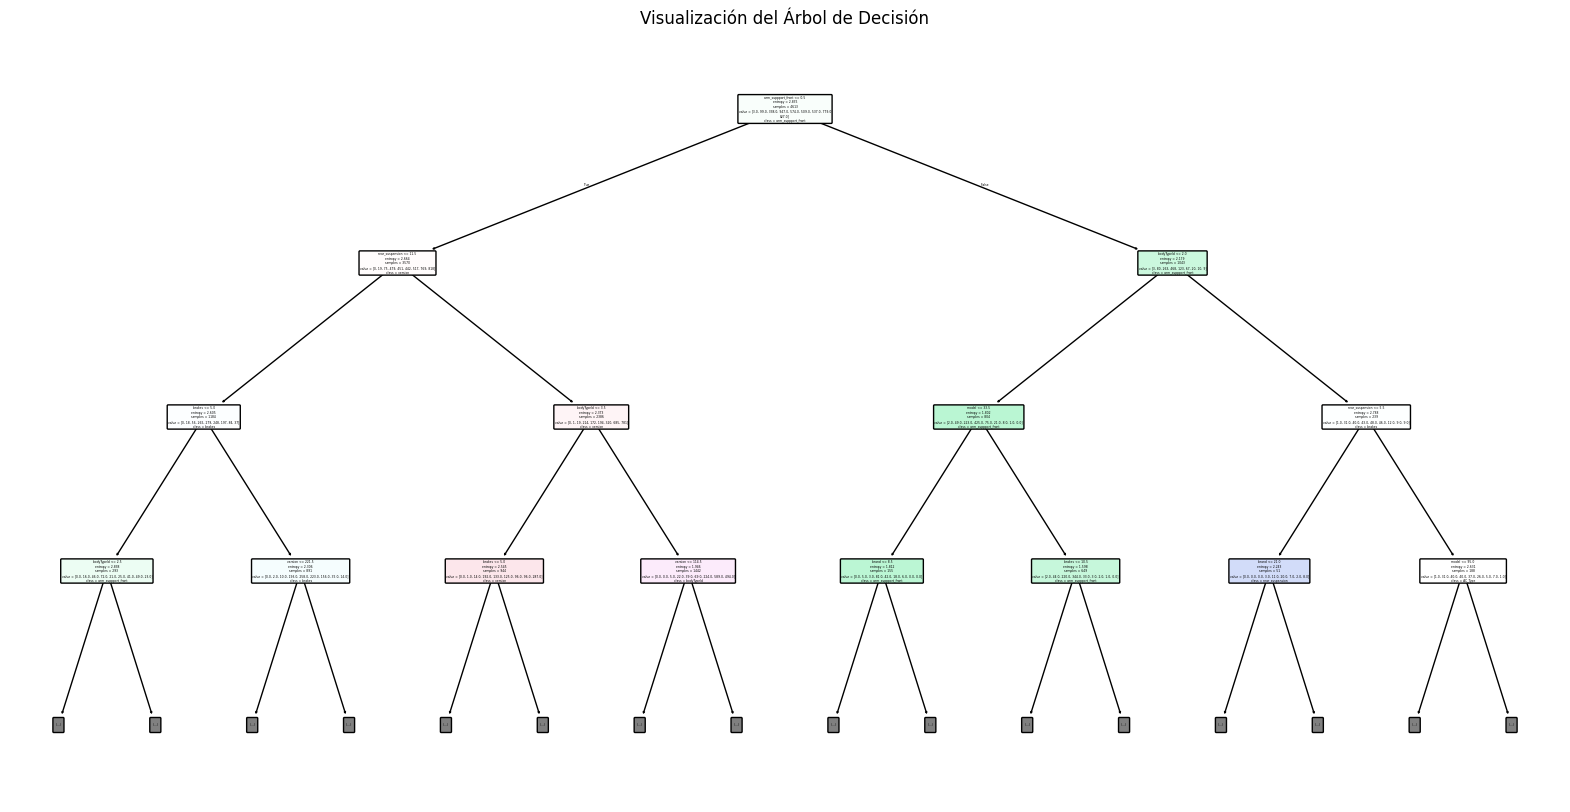

In [28]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

## Electric cars price regression with all the columns